In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import metpy
import numpy as np
from working.sea_breeze.load_barra import load_barra_wind_data, load_barra_variable, load_barra_static
from working.sea_breeze.coastline_funcs import get_coastline_angle, get_coastline
import datetime as dt
import pandas as pd

In [2]:
from climtas.nci import GadiClient
client = GadiClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42013,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:35413,Total threads: 1
Dashboard: /proxy/46773/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44365,


In [3]:
stn_obs = xr.open_dataset("/g/data/w40/clv563/BoM_data_202409/half_hourly_data_netcdf/AWS-data-VIC.nc").sel(time=slice("2023-12-01 00:00","2024-02-29 23:00"))

u,v = metpy.calc.wind_components(
    stn_obs.wspd.metpy.convert_units("m/s"),
    stn_obs.wdir * metpy.units.units.deg)
stn_obs["u"] = u
stn_obs["v"] = v

stn_obs

Magnitude,[[3.156933701120579e-07 1.0555554628372192 2.2827059353858203e-07 ... -2.305556058883667 nan -5.7975592613220215] [0.8930526375770569 2.079038619995117 1.3055554628372192 ... -0.8875356912612915 nan -4.426352024078369] [-0.5402390956878662 1.9997836351394653 -0.36659082770347595 ... -2.3211777210235596 nan -4.3621978759765625] ... [-0.6427876353263855 -0.8930528163909912 -0.26047244668006897 ... 2.3832497596740723 2.079038619995117 -0.25] [-1.8282759189605713 -0.46984630823135376 -0.26047244668006897 ... 2.923488140106201 1.5000001192092896 -0.0] [-2.079038619995117 0.08682411909103394 0.2604723870754242 ... 3.5562503337860107 2.6111111640930176 0.9396926164627075]]
Units,meter/second
Magnitude,[[3.6111111640930176 1.8282760381698608 2.6111111640930176 ... 3.993339776992798 nan 3.3472228050231934] [2.453641891479492 -0.36659058928489685 2.261288642883301 ... 5.033461570739746 nan 2.555555820465088] [3.0638463497161865 2.383249521255493 2.079038619995117 ... 2.7662715911865234 nan 3.660318613052368] ... [0.7660444378852844 2.453641891479492 1.4772117137908936 ... -1.9997833967208862 -0.36659058928489685 -0.4330126941204071] [1.0555557012557983 0.17101004719734192 1.4772117137908936 ... -1.064062476158142 -1.7887321845933002e-08 -0.0] [-0.3665907084941864 0.49240386486053467 1.4772117137908936 ... 0.6270627379417419 -3.113719060365838e-08 -0.34202006459236145]]
Units,meter/second


,name,bmid,lati,long
station,,,,
21,b'YARRAWONGA ...,81124.0,-36.029400,146.030502
23,b'RUTHERGLEN RESEARCH ...,82039.0,-36.104801,146.509399
24,b'WANGARATTA AERO ...,82138.0,-36.420502,146.305603
25,b'HUNTERS HILL ...,82139.0,-36.213699,147.539505
26,b'MOUNT BULLER ...,83024.0,-37.145000,146.439407
27,b'FALLS CREEK ...,83084.0,-36.870800,147.275497
28,b'MOUNT HOTHAM ...,83085.0,-36.977200,147.134201
29,b'OMEO ...,83090.0,-37.101700,147.600800
30,b'GABO ISLAND LIGHTHOUSE ...,84016.0,-37.567902,149.915802


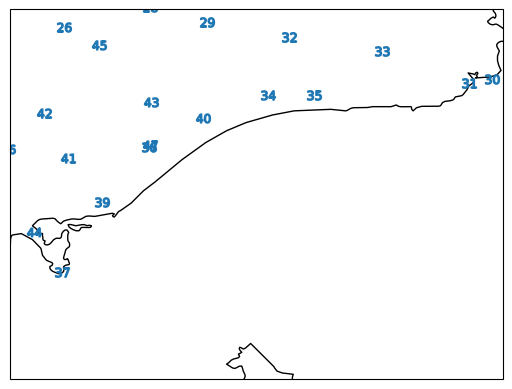

In [4]:
lat_bnds=[-40,-37]
lon_bnds=[146,150]

ax=plt.axes(projection=ccrs.PlateCarree())
[plt.plot(stn_obs.long.sel(station=i),stn_obs.lati.sel(station=i)
          ,ls="none",marker="$"+str(i)+"$",color="tab:blue",ms=10) for i in range(stn_obs.station.shape[0])]
ax.coastlines()
ax.set_ylim(lat_bnds)
ax.set_xlim(lon_bnds)

stn_inds = stn_obs.long >= lon_bnds[0]
stn_obs[["name","bmid","lati","long","station"]].isel(station=stn_inds).to_dataframe()

In [24]:
orog, lsm = load_barra_static("AUS-11", slice(lon_bnds[0],lon_bnds[1]), slice(lat_bnds[0],lat_bnds[1]))
lsm_ds = get_coastline(lsm)
lsm_ds = get_coastline_angle(lsm_ds, r=100, R=300, N=10, small_coast_thresh=0.001)

Defining coastline angles...


100%|██████████| 37/37 [00:00<00:00, 800.54it/s]


Expanding angles to average of closest 10 points within 300 kms...


100%|██████████| 27/27 [00:01<00:00, 25.09it/s]


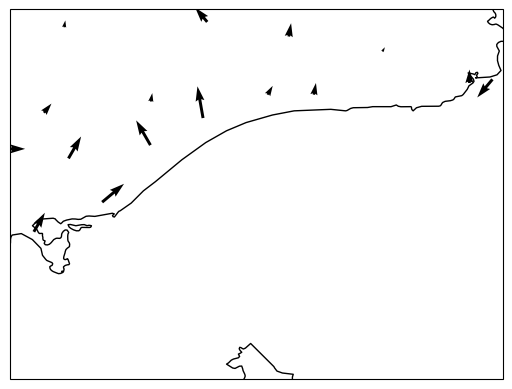

In [47]:
def plot_obs_q(stn_obs, t, ax):
    temp = stn_obs.sel(time=t)
    x = temp.long.values
    y = temp.lati.values
    u = temp.u.values
    v = temp.v.values
    
    ax.quiver(x,y,u,v,scale=150)
    ax.coastlines()
    ax.set_ylim(lat_bnds)
    ax.set_xlim(lon_bnds)


plot_obs_q(stn_obs, "2024-01-29 05:00", plt.axes(projection=ccrs.PlateCarree()))


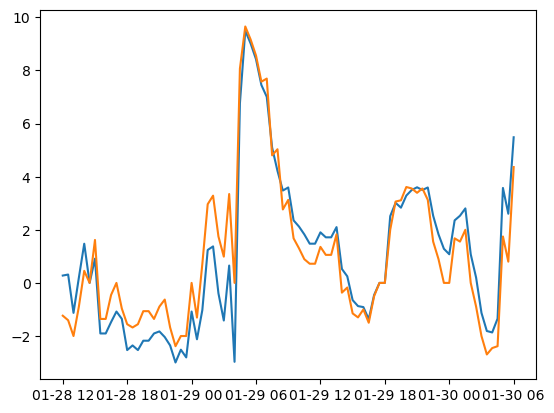

In [48]:
u = stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).u.values
v = stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).v.values
angle = lsm_ds.angles_expanded.sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati,method="nearest").values

uprime = (u * np.cos(np.deg2rad(90-angle))) + (v * np.sin(np.deg2rad(90-angle)))
vprime = (-u * np.sin(np.deg2rad(90-angle))) + (v * np.cos(np.deg2rad(90-angle)))

plt.plot(stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).time, vprime)
plt.plot(stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).time, v)

#Vprime is the cross-shore component based on the rotated wind. However, this approach doesn't consider a consistent +ve/-ve direction (could be either onshore or offshore)